In [75]:
# -*- coding: utf-8 -*-
"""
DDA 3020 Assignment 4

Created on Wed May 3 2023

@author: zhimingmei

"""

'\nDDA 3020 Assignment 4\n\nCreated on Wed May 3 2023\n\n@author: zhimingmei\n\n'

In [76]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os

## PCA without sklearn

In [77]:
data_path = 'PATH'
os.chdir(data_path)

df = pd.read_table('seeds_dataset.txt', delimiter='\t+', header=None)
df

/var/folders/m5/02b5bnp964vfsq01f_4xb42w0000gn/T/ipykernel_2596/2786788438.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_table('seeds_dataset.txt', delimiter='\t+', header=None)


,0,1,2,3,4,5,6,7
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1
...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3


In [78]:
# overview of the data
df.describe()

,0,1,2,3,4,5,6,7
count,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000
mean,14.847524,14.559286,0.870999,5.628533,3.258605,3.700201,5.408071,2.000000
std,2.909699,1.305959,0.023629,0.443063,0.377714,1.503557,0.491480,0.818448
min,10.590000,12.410000,0.808100,4.899000,2.630000,0.765100,4.519000,1.000000
25%,12.270000,13.450000,0.856900,5.262250,2.944000,2.561500,5.045000,1.000000
50%,14.355000,14.320000,0.873450,5.523500,3.237000,3.599000,5.223000,2.000000
75%,17.305000,15.715000,0.887775,5.979750,3.561750,4.768750,5.877000,3.000000
max,21.180000,17.250000,0.918300,6.675000,4.033000,8.456000,6.550000,3.000000


In [79]:
len = df.__len__()
X = df.loc[:, :6]
y = df.loc[:, 7]
# standardize the data
X = (X-X.mean()) / X.std(ddof=0)

<AxesSubplot:>

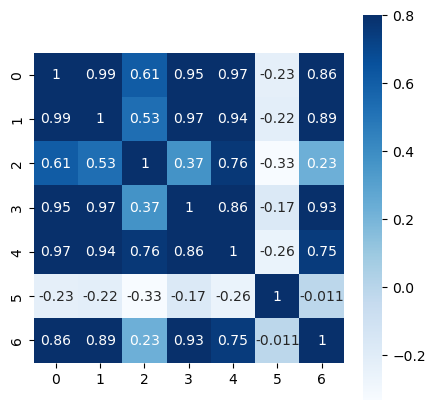

In [80]:
# calculate the correlation
X_correlation = (1 / len) * X.T.dot(X)

plt.figure(figsize=(5,5))
sns.heatmap(X_correlation, vmax=.8, square=True, annot=True, cmap='Blues')

In [81]:
# svd decomposition, to get the eigenvalues and eigenvectors
u, s, v = np.linalg.svd(X_correlation)
eig_values, eig_vectors = s, u

eig_sum = np.sum(eig_values)

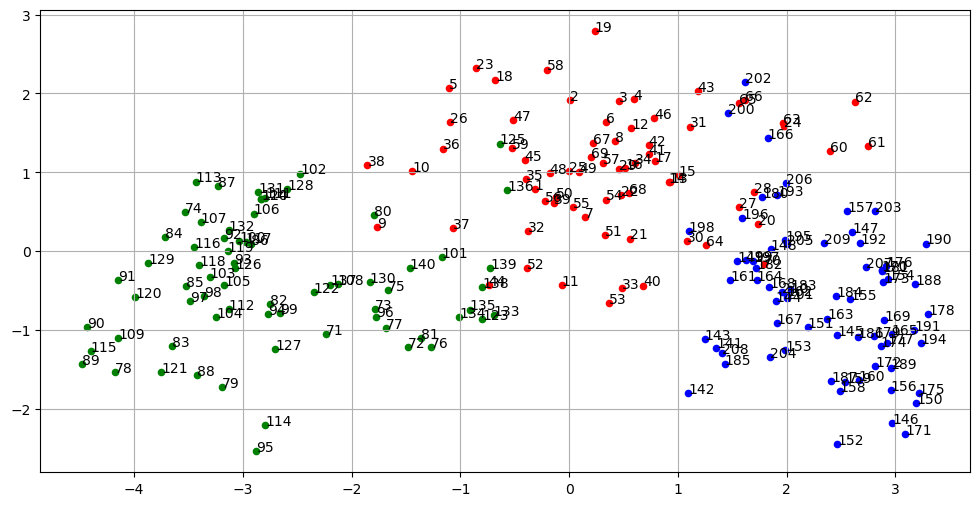

In [82]:
# new axis
pc1 = X.dot(eig_vectors[:, 0])
pc2 = X.dot(eig_vectors[:, 1])

# show the pca results
def show_pc(pc1, pc2):
    '''
    Show the pca results
    '''
    fig, ax = plt.subplots(figsize=(12, 6))
    
    label_unique = list(set(y))

    for i, label_ in enumerate(y):
        plt.scatter(pc1[i], pc2[i], label = label_, s = 20, c=['r', 'g', 'b'][label_unique.index(label_)])
        ax.annotate(str(i+1), (pc1[i],pc2[i]))
    plt.grid()
    plt.show()

show_pc(pc1, pc2)

### PCA with sklearn
Just for comparison. And from the figure below, the results are identical.

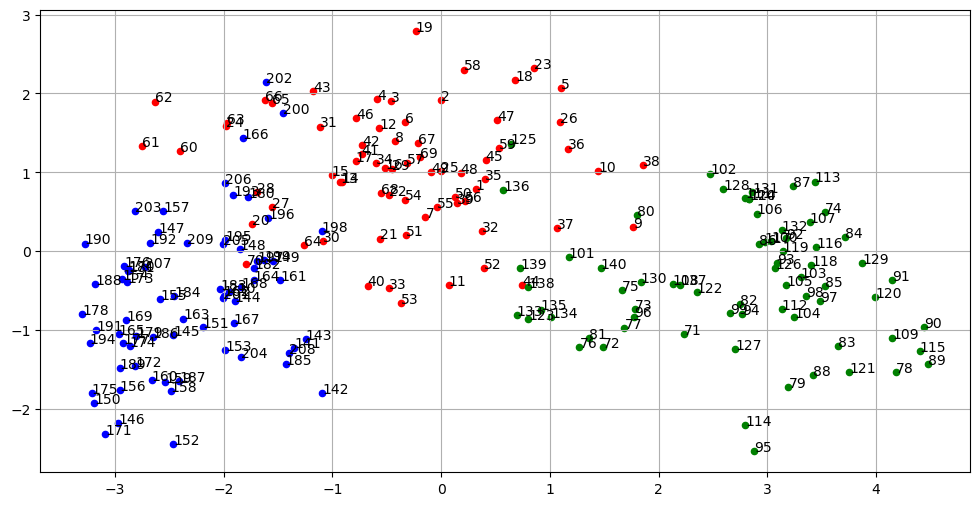

In [83]:
from sklearn.decomposition import PCA
pca = PCA()
pca_new = pca.fit_transform(X)
pc1 = pca_new[:, 0]
pc2 = pca_new[:, 1]

show_pc(pc1, pc2)

## K-means

In [84]:
def initialize_centroids(X, k):
    '''
    Randomly choose a centroid
    '''
    return X[np.random.choice(len, size=k, replace=False)]

def assign_classes(X, centroids):
    '''
    Assign all the data to the neareast classes

    Returns:
        the indices of the minimum distance
    '''
    distances = []
    for x in X:
        distances.append([np.linalg.norm(x - c) for c in centroids])
    return np.argmin(distances, axis=1)

def update_centroids(X, classes, k):
    '''
    Update the position of centroids by calculating the mean of each cluster
    '''
    centroids = np.zeros((k, X.shape[1]))
    for j in range(k):
        centroids[j] = np.mean(X[classes == j], axis=0)
    return centroids

def check_convergence(centroids, prev_centroids, tol):
    '''
    Check whether the program is convergent or not

    Returns:
        True if centroids and prev_centroids are equal within the tolerance
    '''
    return np.allclose(centroids, prev_centroids, rtol=0, atol=tol)

def kmeans(X, k=3, max_iters=100, tol=1e-4):
    '''
    Implementation of Kmeans
    
    Returns:
        centroids stored in (k*d) matrix, where k is the number of unique classes, and d is the dimension of the data 
        classes
    '''
    centroids = initialize_centroids(X, k)
    
    for i in range(max_iters):
        classes = {}
        for j in range(k):
            classes[j] = []
        
        classes = {j: [] for j in range(k)}
        for x in X:
            distances = [np.linalg.norm(x - c) for c in centroids]
            min_dist = np.argmin(distances)
            classes[min_dist].append(x)
        
        prev_centroids = centroids.copy()
        centroids = update_centroids(X, assign_classes(X, centroids), k)
        
        if check_convergence(centroids, prev_centroids, tol):
            break
    
    return centroids, assign_classes(X, centroids)


In [85]:
# we use the pca data
pc1 = pc1.tolist()
pc2 = pc2.tolist()
data = {'pc1':pc1, 'pc2': pc2}
X = pd.DataFrame(data)
X = X.values

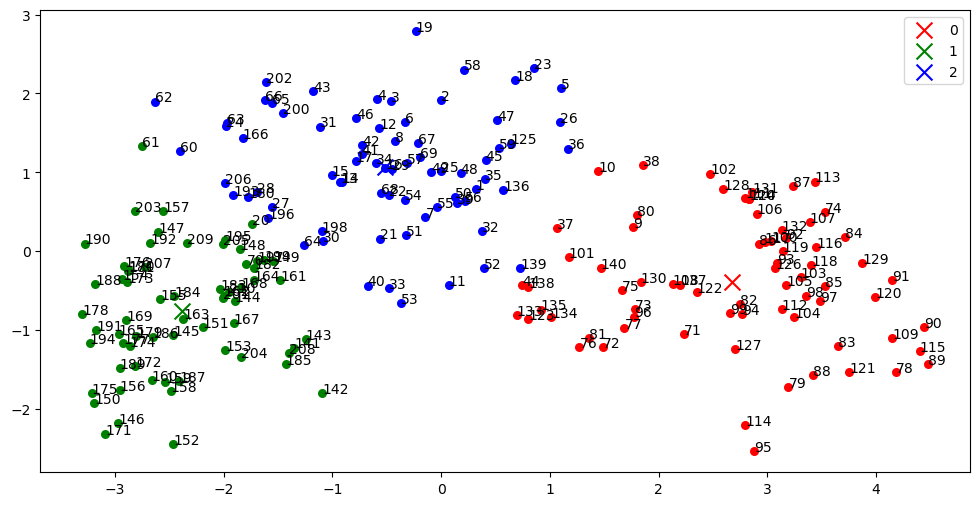

In [86]:
# kmeans
centroids, classes = kmeans(X, k=3)

# plot the centroids and points
fig, ax = plt.subplots(figsize=(12, 6))
colors = ['r', 'g', 'b']
for i, centroid in enumerate(centroids):
    # plot the centroids
    plt.scatter(centroid[0], centroid[1], s=130, marker="x", color=colors[i])
    
for i, pc in enumerate(X):
    # plot the points
    plt.scatter(pc[0], pc[1], color=colors[classes[i]], s=30)
    ax.annotate(str(i+1), (pc[0],pc[1]))
    ax.legend(list(set(classes)))
plt.show()

## Performance Evaluation
### Silhouette Coefficient

In [87]:
def silhouette(X, classes, centroids):
    '''
    Calculate the Silhouette coefficient

    Returns:
        The mean value of silhouette coefficient from all samples
    '''
    s = 0 # silhouette coefficient
    for i in range(len):
        classes_lst = classes.tolist()
        classes_unique = list(set(classes_lst))
        x = X[i]
        ci = classes[i]
        ai = np.mean([np.linalg.norm(x-X[j]) for j in np.where(classes==ci)]) # in the same cluster
        bi = min([np.mean([np.linalg.norm(x - X[j]) for j in np.where(classes==c)]) for c in classes_unique if c != ci]) # in nearest clusters
        si = (bi-ai) / max(ai, bi) # silhouette coefficient of each sample
        s += si
    return s/len

In [88]:
sc = silhouette(X, classes, centroids)
print(f'The Silhouette score is {sc}')

The Silhouette score is 0.4732354464473649


### Rand Index

In [89]:
def combinations(x):
    '''
    Generate all possible combinations

    Reference: https://carlostgameiro.medium.com/fast-pairwise-combinations-in-numpy-c29b977c33e2

    Returns:
        All possible combinations in array
    '''
    idx = np.stack(np.triu_indices(len, k=1), axis=-1)
    return x[idx]

def rand_index(y_true, y_pred):
    '''
    Compute Rand Index
    '''
    true_comb = list(combinations(y_true))
    pred_comb = list(combinations(y_pred))

    true_dist = np.array([a==b for a, b in true_comb])
    pred_dist = np.array([a==b for a, b in pred_comb])

    tp = np.sum(true_dist * pred_dist)
    tn = np.sum((1-true_dist) * (1-pred_dist))
    fp = np.sum((1-true_dist) * pred_dist)
    fn = np.sum(true_dist * (1-pred_dist))

    return (tp+tn) / (tp+tn+fp+fn)

In [90]:
y = np.array(y)

ri = rand_index(y, classes)
print(f'The Rand Index score is {ri}')

The Rand Index score is 0.8890407837776259
